In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
pd.pandas.set_option('display.max_columns',None)

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV,  KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

In [3]:
train_data = pd.read_csv("../data/train_processed_data.csv")
train_data.shape

(39980, 18)

In [4]:
from sklearn import metrics
def model_compare(model_name,model,y_test,y_pred,y_score, roc_auc = None):
    binclass_metrics = {
                        'Accuracy' : metrics.accuracy_score(y_test, y_pred),
                        'Precision' : metrics.precision_score(y_test, y_pred),
                        'Recall' : metrics.recall_score(y_test, y_pred),
                        'F1 Score' : metrics.f1_score(y_test, y_pred),
                        'ROC AUC' : roc_auc
                       }

    df_metrics = pd.DataFrame.from_dict(binclass_metrics, orient='index')
    df_metrics.columns = [model_name] 
    return df_metrics

In [5]:
x = train_data.drop(['y'],axis =1).values
y = train_data['y'].values
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size =0.3, random_state=303)

In [6]:
print("Shape of Training Data",x_train.shape)
print("Shape of Testing Data",x_test.shape)
print("Response Rate in Training Data",y_train.mean())
print("Response Rate in Testing Data",y_test.mean())

Shape of Training Data (27986, 17)
Shape of Testing Data (11994, 17)
Response Rate in Training Data 0.09904952476238119
Response Rate in Testing Data 0.09971652492913123


In [7]:
# as the Sample was not Balanced we are using the SMOTE technique
from imblearn.over_sampling import SMOTENC

In [8]:
# we need to get the categorical feature column position
actual_data = pd.read_excel("../data/bank_telemaketing.xlsx")
actual_data.shape
categorical_features=[feature for feature in actual_data.columns if actual_data[feature].dtype=='O' and feature != 'y']

In [9]:
position = 0
column_position = []
for feature in train_data.columns:
    if feature in categorical_features:
        column_position.append(position)
    position+=1    
column_position    

[1, 2, 3, 4, 5, 6, 7, 8, 9, 13]

In [10]:
train_data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'poutcome', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'y'],
      dtype='object')

In [11]:
# applying over sampeling
smotenc = SMOTENC(column_position,random_state = 303)
x_oversample, y_oversample = smotenc.fit_resample(x_train, y_train)

## DecisionTree

In [12]:
from sklearn.tree import DecisionTreeClassifier

In [30]:
model_dt = DecisionTreeClassifier(random_state=303)
np.random.seed(303)
# start = time.time()
param_dist = {'max_depth': [4, 5, 6, 7, 8],
              'min_samples_leaf':[100,200,70, 30],
              'criterion': ['gini', 'entropy']}

cv_rf = GridSearchCV(model_dt, cv = 10,
                     param_grid=param_dist, 
                     n_jobs = 1)

cv_rf.fit(x_train, y_train)
print('Best Parameters using grid search: \n', cv_rf.best_params_)

Best Parameters using grid search: 
 {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 30}


In [13]:
model_dt = DecisionTreeClassifier(random_state=303,
                                  max_depth=6, 
                                  criterion = 'gini', 
                                  min_samples_leaf=30 )
model_dt.fit(x_train, y_train)
model_dt_score_train = model_dt.score(x_train, y_train)
print("Training score: ",model_dt_score_train)
model_dt_score_test = model_dt.score(x_test, y_test)
print("Testing score: ",model_dt_score_test)

y_pred = model_dt.predict(x_test)
print(f"Accuracy = > {y_pred}")
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr_dt, tpr_dt)
y_score = accuracy_score(y_test, y_pred)
metrix_dt = model_compare("Decision Tree",model_dt, y_test, y_pred, y_score, roc_auc  )
metrix_dt

Training score:  0.9264989637675981
Testing score:  0.9187093546773387
Accuracy = > [0 1 0 ... 0 0 0]


,Decision Tree
Accuracy,0.918709
Precision,0.613800
Recall,0.498328
F1 Score,0.550069
ROC AUC,0.731800


In [31]:
# with Over Sampeling
model_somte_dt = DecisionTreeClassifier(random_state=303)
np.random.seed(303)
# start = time.time()
param_dist = {'max_depth': [4, 5, 6, 7, 8],
              'min_samples_leaf':[100,200,70, 30],
              'criterion': ['gini', 'entropy']}

cv_rf = GridSearchCV(model_dt, cv = 10,
                     param_grid=param_dist, 
                     n_jobs = 1)

cv_rf.fit(x_oversample, y_oversample)
print('Best Parameters using grid search: \n', cv_rf.best_params_)

Best Parameters using grid search: 
 {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 30}


In [14]:
model_somte_dt = DecisionTreeClassifier(random_state=303,
                                  max_depth=8, 
                                  criterion = 'gini', 
                                  min_samples_leaf=30 )
model_somte_dt.fit(x_oversample, y_oversample)
model_somte_dt_score_train = model_dt.score(x_oversample, y_oversample)
print("Training score: ",model_somte_dt_score_train)
model_somte_dt_score_test = model_somte_dt.score(x_test, y_test)
print("Testing score: ",model_somte_dt_score_test)

y_pred = model_somte_dt.predict(x_test)
print(f"Accuracy = > {y_pred}")
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr_dt, tpr_dt)
y_score = accuracy_score(y_test, y_pred)
metrix_smote_dt = model_compare("Decision Tree with SMOTE",model_somte_dt, y_test, y_pred, y_score, roc_auc  )
metrix_smote_dt

Training score:  0.7401443642420877
Testing score:  0.8781057195264299
Accuracy = > [0 1 1 ... 0 0 0]


,Decision Tree with SMOTE
Accuracy,0.878106
Precision,0.437850
Recall,0.783445
F1 Score,0.561751
ROC AUC,0.836018


## Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
model_rf = RandomForestClassifier(random_state=303)

In [17]:
param_dist = {'max_depth': [3,4,5,7,8],
              'bootstrap': [True, False],
              'max_features': ['auto', 'sqrt', 'log2', None],
              'criterion': ['gini', 'entropy']}

cv_rf = GridSearchCV(model_rf, cv = 10,
                     param_grid=param_dist, 
                     n_jobs = 1)

cv_rf.fit(x_train, y_train)
print('Best Parameters using grid search: \n', cv_rf.best_params_)

Best Parameters using grid search: 
 {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 8, 'max_features': None}


In [18]:
model_rf.set_params(criterion    = 'entropy',
                    max_features = None, 
                    max_depth    = 8,
                    bootstrap    = True,
                    random_state=303
                   )

RandomForestClassifier(criterion='entropy', max_depth=8, max_features=None,
                       random_state=303)

In [23]:
model_rf.set_params(warm_start=True, 
                  oob_score=True)

min_estimators = 1000
max_estimators = 2000

error_rate = {}

for i in range(min_estimators, max_estimators + 1):
    model_rf.set_params(n_estimators=i)
    model_rf.fit(x_train, y_train)

    oob_error = 1 - model_rf.oob_score_
    error_rate[i] = oob_error

oob_series = pd.Series(error_rate)

Text(0.5, 1.0, 'OOB Error Rate Across various Forest sizes \n(From 15 to 1000 trees)')

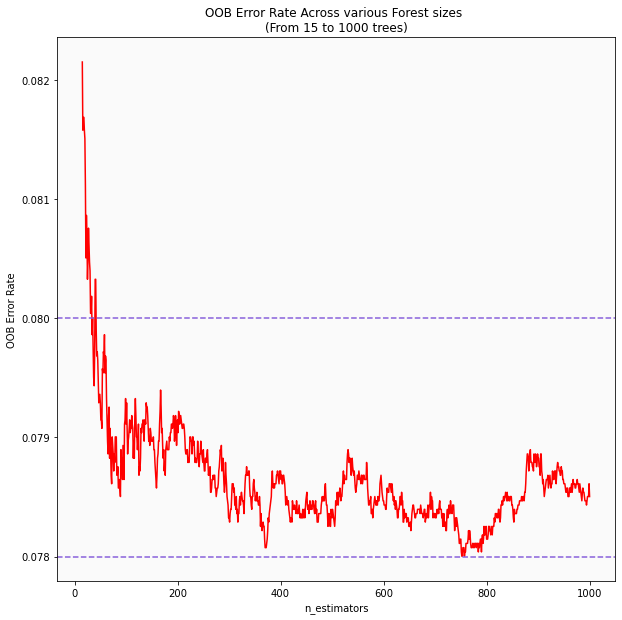

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_facecolor('#fafafa')

oob_series.plot(kind='line',color = 'red')
plt.axhline(0.08, color='#875FDB',linestyle='--')
plt.axhline(0.078, color='#875FDB',linestyle='--')
plt.xlabel('n_estimators')
plt.ylabel('OOB Error Rate')
plt.title('OOB Error Rate Across various Forest sizes \n(From 15 to 1000 trees)')

Text(0.5, 1.0, 'OOB Error Rate Across various Forest sizes \n(From 1000 to 2000 trees)')

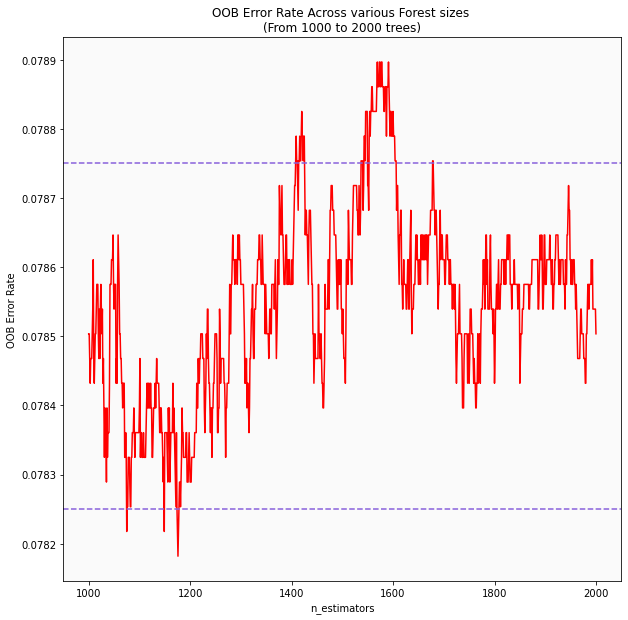

In [26]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_facecolor('#fafafa')

oob_series.plot(kind='line',color = 'red')
plt.axhline(0.07875, color='#875FDB',linestyle='--')
plt.axhline(0.07825, color='#875FDB',linestyle='--')
plt.xlabel('n_estimators')
plt.ylabel('OOB Error Rate')
plt.title('OOB Error Rate Across various Forest sizes \n(From 1000 to 2000 trees)')

In [27]:
model_rf.set_params(n_estimators=1380,
                    bootstrap = True,
                    warm_start=False, 
                    oob_score=False)

RandomForestClassifier(criterion='entropy', max_depth=8, max_features=None,
                       n_estimators=1380, random_state=303)

In [28]:
model_rf.fit(x_train, y_train)
prediction_test = model_rf.predict(x_test)
y_score= metrics.accuracy_score(y_test, prediction_test)
y_pred= model_rf.predict(x_test)
#########################################################
y_pred = model_rf.predict_proba(x_test)[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred)
roc_auc_rf = auc(fpr_dt, tpr_dt)
#########################################################
metrix_rf = model_compare("Random Forest",model_rf, y_test, prediction_test, y_score , roc_auc_rf )
metrix_rf

,Random Forest
Accuracy,0.921961
Precision,0.637131
Recall,0.505017
F1 Score,0.563433
ROC AUC,0.950280
